In [1]:
import numpy as np
from scipy import stats
import astropy.units as u
from astropy.coordinates import SkyCoord, get_sun, GeocentricTrueEcliptic, Angle
from astropy.wcs import WCS
from astropy.time import Time
from astropy.table import Table
from astropy.visualization import hist
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors

In [2]:
from imp import reload

In [3]:
%matplotlib inline

In [4]:
rcParams['figure.figsize'] = 14, 9

In [7]:
import astroimsim

In [39]:
reload(astroimsim)

<module 'astroimsim' from '/mnt/data/ajh/Documents/Spaaaaaaaaaaaaaaaaaaaaaace/HuntsmanInSpace/Simulations/astroimsim/astroimsim.py'>

# Zodiacal Light

ZodicalLight class constructs a zodical light model based on that used by the HST ETC.

## Initialise zodical light model

In [25]:
zl = astroimsim.ZodiacalLight()

## Absolute spectral photon flux density surface brightness

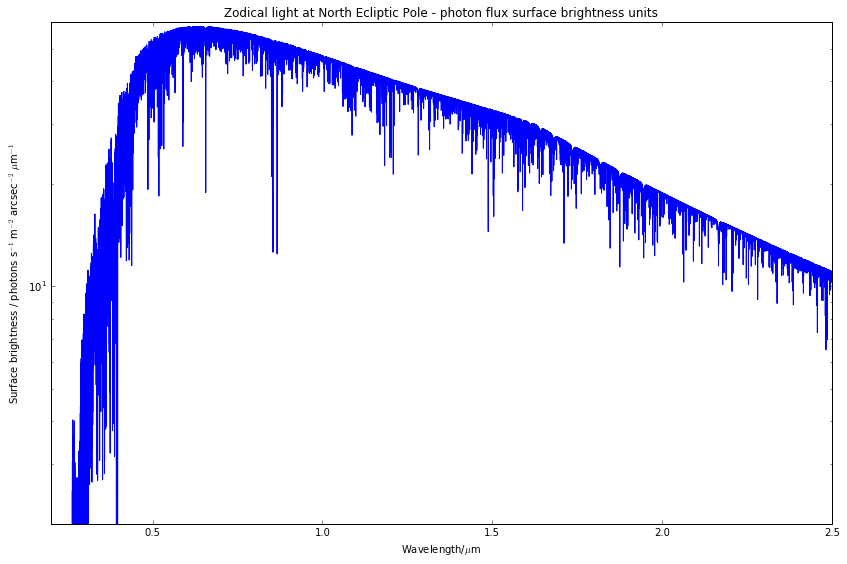

In [26]:
plt.semilogy(zl.waves, zl.photon_sfd, label='Zodical Light - NEP')
plt.xlim(0.2,2.5)
plt.ylim(2e-0,6e1)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Surface brightness / photons s$^{-1}$ m$^{-2}$ arcsec$^{-2}$ $\mu$m$^{-1}$')
plt.title('Zodical light at North Ecliptic Pole - photon flux surface brightness units');

## Relative surface brightness as a function of sky position.

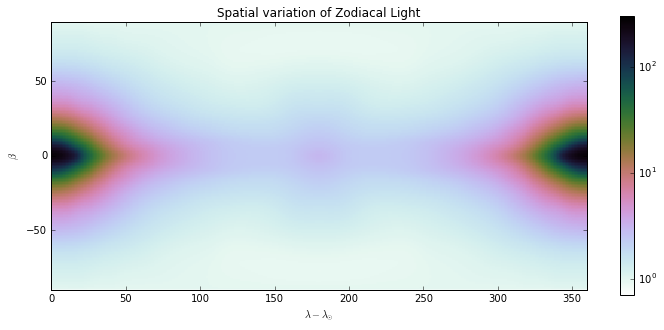

In [27]:
plt.imshow(zl._spatial(np.linspace(0,np.pi,180),np.linspace(0,2*np.pi,360)), \
           origin='lower', extent=[0,360,-90,90], norm=colors.LogNorm(vmin=0.7,vmax=300), \
           interpolation='none', cmap='cubehelix_r')
plt.colorbar()
plt.title('Spatial variation of Zodiacal Light')
plt.xlabel('$\lambda - \lambda_{\odot}$')
plt.ylabel('$\\beta$')
plt.gcf().set_size_inches(12, 5)

# Imager

Imager class represents an imaging instrument

## Set up imager parameters

### Entrance aperture area (astropy Quantity)

Here we assume an unobstructed circular aperture of 90 mm diameter.

In [28]:
pupil_area = (np.pi * (90 * u.mm)**2 / 4).si
pupil_area

<Quantity 0.0063617251235193305 m2>

### Optical throughput (astropy Table)

The Table should have 'Wavelength' and 'Throughput' columns with specified units. In real instruments there will be some degree of field dependance, that is not implemented yet.

A very simplistic estimate, neglect bulk absorption and assume a constant 99.5% transmission at each vacuum-glass surface.

In [53]:
n_surfaces = 7
wavelengths = np.array((250, 1050)) * u.nm
t = np.array((0.995**n_surfaces, 0.995**n_surfaces)) * u.dimensionless_unscaled
throughput = Table(names = ('Wavelength', 'Throughput'), data = (wavelengths, t))
throughput

Wavelength,Throughput
nm,
float64,float64
250.0,0.965520646809
1050.0,0.965520646809


### Filter transmission functions (Python dictionary of astropy Tables)

Keys of the dictionary should be filter name strings, the Tables should have 'Wavelength' and 'Transmission' columns with specified units.

Here we use nominal Space Eye filter profiles derived from Chebyshev Type I filter functions of order 50, ripple factor 0.14, and peak transmission set to 0.95. These have properties similar to a real optical bandpass filter, e.g. they fairly closely resemble the DECam $i'$ and $z'$ filters but with somewhat sharper edges (facilitated by the slower focal ratio).

In [30]:
N = 50
r = 0.14

filters = {"i1":Table((zl.waves, astroimsim.cheby_band(zl.waves, 700*u.nm, 850.0 * u.nm, N, ripple=r)), \
                      names = ['Wavelength', 'Transmission']), \
           "i2":Table((zl.waves, astroimsim.cheby_band(zl.waves, 700*u.nm, 855.5 * u.nm, N, ripple=r)), \
                      names = ['Wavelength', 'Transmission']), \
           "i3":Table((zl.waves, astroimsim.cheby_band(zl.waves, 700*u.nm, 861.0 * u.nm, N, ripple=r)), \
                      names = ['Wavelength', 'Transmission']), \
           "z1":Table((zl.waves, astroimsim.cheby_band(zl.waves, 854.0*u.nm, 1000 * u.nm, N, ripple=r)), \
                      names = ['Wavelength', 'Transmission']), \
           "z2":Table((zl.waves, astroimsim.cheby_band(zl.waves, 859.5*u.nm, 1000 * u.nm, N, ripple=r)), \
                      names = ['Wavelength', 'Transmission']), \
           "z3":Table((zl.waves, astroimsim.cheby_band(zl.waves, 865.0*u.nm, 1000 * u.nm, N, ripple=r)), \
                      names = ['Wavelength', 'Transmission'])}

for f in filters.values():
    # Set units correctly
    f['Wavelength'] = f['Wavelength'].to(u.um)
    f['Wavelength'].unit = u.um
    f['Transmission'].unit = u.dimensionless_unscaled

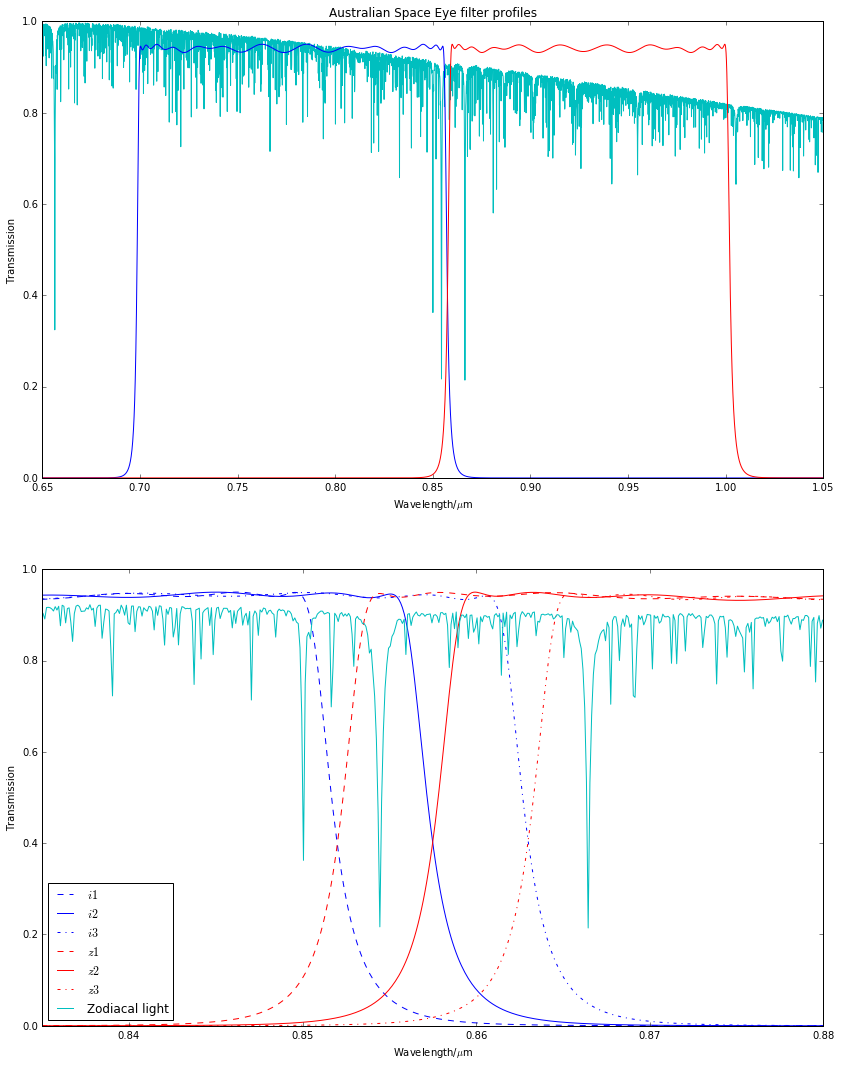

In [31]:
plt.subplot(2,1,1)

plt.plot(zl.waves, zl.photon_sfd/zl.photon_sfd.max(), 'c-', label='Zodiacal light')
plt.plot(filters['i2']['Wavelength'], filters['i2']['Transmission'], 'b-')
plt.plot(filters['z2']['Wavelength'], filters['z2']['Transmission'], 'r-')

plt.xlim(0.65,1.05)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Transmission')
plt.title('Australian Space Eye filter profiles')

plt.subplot(2,1,2)
plt.plot(filters['i1']['Wavelength'], filters['i1']['Transmission'], 'b--', label='$i1$')
plt.plot(filters['i2']['Wavelength'], filters['i2']['Transmission'], 'b-', label='$i2$')
plt.plot(filters['i3']['Wavelength'], filters['i3']['Transmission'], 'b-.', label='$i3$')
plt.plot(filters['z1']['Wavelength'], filters['z1']['Transmission'], 'r--', label='$z1$')
plt.plot(filters['z2']['Wavelength'], filters['z2']['Transmission'], 'r-', label='$z2$')
plt.plot(filters['z3']['Wavelength'], filters['z3']['Transmission'], 'r-.', label='$z3$')

plt.plot(zl.waves, zl.photon_sfd/zl.photon_sfd.max(), 'c-', label='Zodiacal light')
plt.xlim(0.835,0.88)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Transmission')  
plt.legend(loc='best')
plt.gcf().set_size_inches(14, 18)

#plt.gcf().set_size_inches(8, 12)
#plt.savefig('filters.pdf')

### Image sensor quantum efficiency (astropy Table)

The Table should have 'Wavelength' and 'QE' columns with specified units.

Here we use QE data for the e2v CIS115 image sensor at -40$^\circ$C extracted from a plot in Soman et el (2014).

In [32]:
qe_m40C = Table.read('../resources/cis115_QE_-40C.csv')
qe_m40C['Wavelength'].unit = u.um
qe_m40C['QE'].unit = u.electron / u.photon

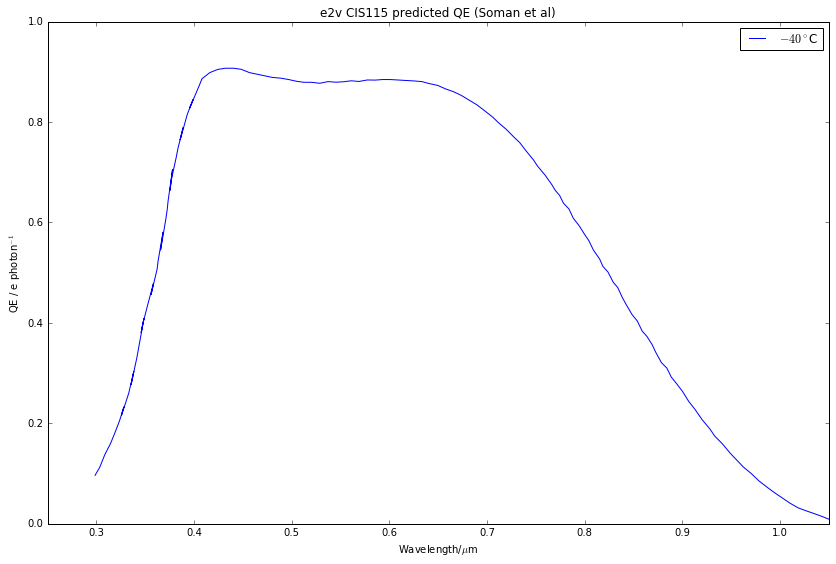

In [33]:
plt.plot(qe_m40C['Wavelength'], qe_m40C['QE'], label='$-40^\circ$C')
plt.xlim(0.25,1.05)
plt.ylim(0,1)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('QE / e photon$^{-1}$')
plt.legend(loc='best')
plt.title('e2v CIS115 predicted QE (Soman et al)')

### Image sensor gain

In [34]:
gain = 1.0 * u.electron / u.adu # Well below read noise, easily accommodates dynamic range in 16 bits

### Read noise

In [35]:
read_noise = 4.0 * u.electron

### Dark current

At visible wavelengths the dominant source of instrumental background will be the dark current of the image sensor.  Wang et al (2014), http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=1891414, measured the dark current of an e2v CMOS image sensor prototype (CIS107) between 250 and 300 K and found that the dark current was well fit by
$D = 10^{0.0488T - 12.772}$ e$^-$ s$^{-1}$ pixel$^{-1}$, where $T$ is the temperature in Kelvin.  

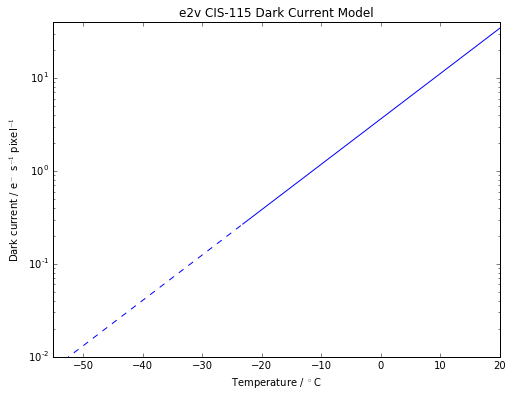

In [134]:
Ts = np.arange(250,301,10) * u.Kelvin
Ts2 = np.arange(220,251,10) * u.Kelvin
DSs = 10**(0.0488 * Ts.value - 12.772) * u.electron * u.second**-1 * u.pixel**-1
DSs2 = 10**(0.0488 * Ts2.value - 12.772) * u.electron * u.second**-1 * u.pixel**-1
plt.semilogy(Ts.to(u.deg_C, equivalencies=u.temperature()), DSs)
plt.semilogy(Ts2.to(u.deg_C, equivalencies=u.temperature()), DSs2, 'b--')
plt.xlim(-55,20)
plt.ylim(0.01,40)
plt.xlabel('Temperature / $^\circ$C')
plt.ylabel('Dark current / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('e2v CIS-115 Dark Current Model')
#plt.savefig('CIS115DC.png')
plt.gcf().set_size_inches(8, 6)
plt.savefig('CIS115DC.pdf')

For our nominal operating temperature of -40$^\circ$C we get

In [37]:
temperature = (-40 * u.deg_C).to(u.K, equivalencies=u.temperature())
dark_current = 10**(0.0488 * temperature.value - 12.772) * u.electron * u.second**-1 * u.pixel**-1
dark_current

<Quantity 0.04033852370388624 electron / (pix s)>

## Create an Imager instance to represent the instrument

This will result in a template WCS being created and effective aperture areas (aperture area x optical throughout x image sensor QE) as a function of wavelength being precalculated for each filter.

In [54]:
ase = astroimsim.Imager(2000, 1504, 3 * u.arcsecond, pupil_area, throughput, filters, \
                        qe_m40C, gain, read_noise, temperature, zl)

In [55]:
ase.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 0.0  0.0  
CRPIX : 1000.5  752.5  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00083333333333333328  0.00083333333333333328  
NAXIS    : 2000 1504

### Check effective areas

In [56]:
ase._eff_areas["i1"]['Effective Area'].unit

Unit("electron m2 / ph")

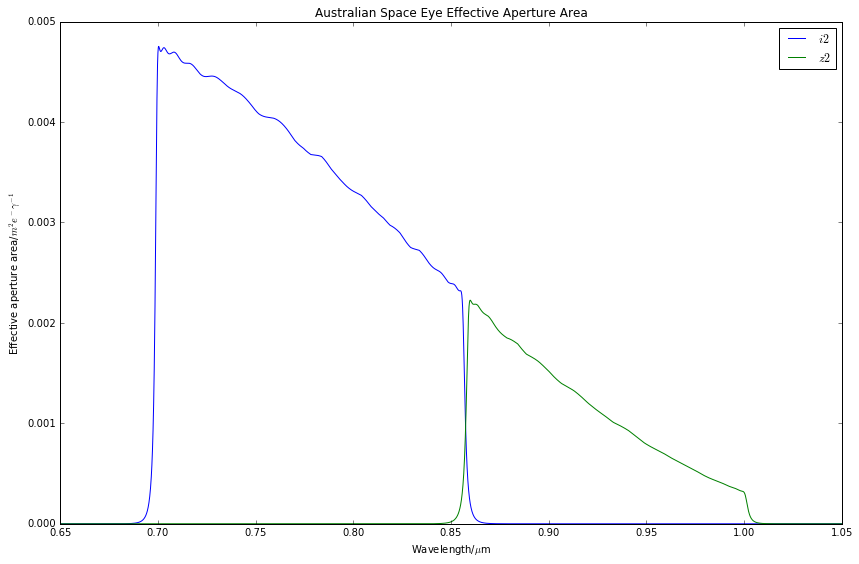

In [57]:
plt.plot(ase._eff_areas["i2"]['Wavelength'], ase._eff_areas["i2"]['Effective Area'], label="$i2$")
plt.plot(ase._eff_areas["z2"]['Wavelength'], ase._eff_areas["z2"]['Effective Area'], label="$z2$")
plt.xlim(0.65, 1.05)
plt.ylim(0,0.005)
plt.xlabel('Wavelength/$\mu$m')
plt.ylabel('Effective aperture area/$m^2 e^- \gamma^{-1}$')
plt.legend()
plt.title('Australian Space Eye Effective Aperture Area')

### Check observed Zodiacal light normalisation

In [58]:
ase._zl_ep

{'i1': <Quantity 0.03081828402512441 electron / (arcsec2 s)>,
 'i2': <Quantity 0.03143722550020661 electron / (arcsec2 s)>,
 'i3': <Quantity 0.03205334706260966 electron / (arcsec2 s)>,
 'z1': <Quantity 0.008787292484020487 electron / (arcsec2 s)>,
 'z2': <Quantity 0.008170885335179342 electron / (arcsec2 s)>,
 'z3': <Quantity 0.007547432329835031 electron / (arcsec2 s)>}

Ecliptic pole observed Zodical light photoelectrons per second based on nominal pixel scale

In [59]:
for f in sorted(ase.filters):
    print(f, ase._zl_ep[f] * ase.pixel_scale**2)

i1 0.2773645562261197 electron / s
i2 0.2829350295018595 electron / s
i3 0.28848012356348696 electron / s
z1 0.07908563235618439 electron / s
z2 0.07353796801661408 electron / s
z3 0.06792689096851527 electron / s


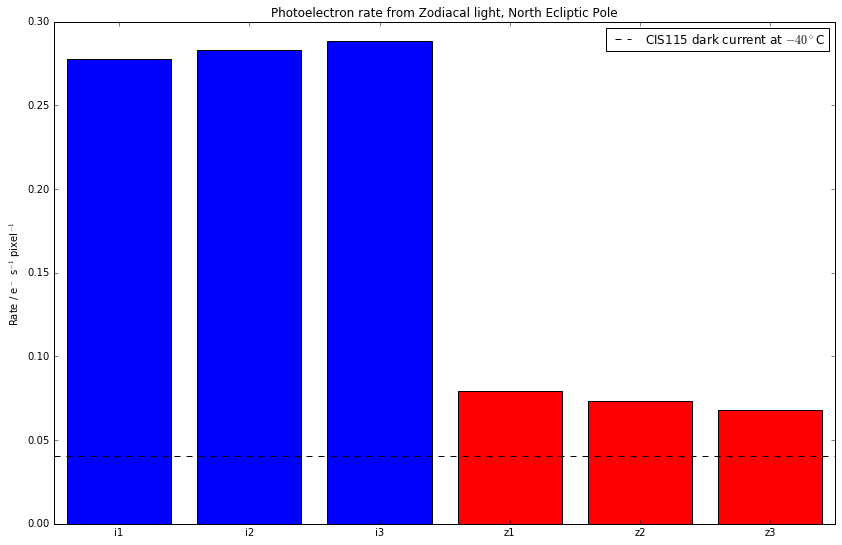

In [132]:
plt.bar([1,2,3,4,5, 6], [(ase._zl_ep[f] * ase.pixel_scale**2).value for f in sorted(ase.filters)], \
        align='center', color=('b','b','b','r','r', 'r'))
plt.hlines(ase.dark_current.value, 0.5, 6.5, linestyle='dashed', label='CIS115 dark current at $-40^\circ$C')
plt.xlim(0.5,6.5)
plt.legend(loc='best')
plt.xticks((1,2,3,4,5,6), sorted(ase.filters.keys()))
plt.ylabel('Rate / e$^-$ s$^{-1}$ pixel$^{-1}$')
plt.title('Photoelectron rate from Zodiacal light, North Ecliptic Pole')

SNR in faint source limit $\propto \frac{1}{\sqrt{St + Dt + r^2}}$

Relative SNR (relative to zero instrumental noise) $= (1 + \frac{D + r^2/t}{S})^{-1/2}$

In [73]:
def rel_snr(t, T, f):
    S = (ase._zl_ep[f] * ase.pixel_scale**2).value
    D = 10**(0.0488 * T.to(u.Kelvin, u.temperature()).value - 12.772)
    return (1 + (D + ase.read_noise.value**2/t)/S)**-0.5

/mnt/data/ajh/Documents/virtualenvs/python3.4.3/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


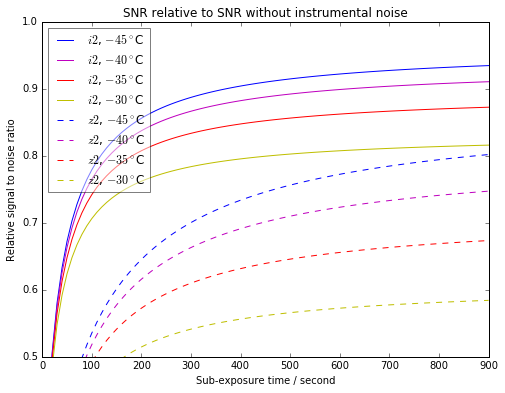

In [137]:
ts = np.arange(0,901,10)
plt.plot(ts, rel_snr(ts, -45 * u.Celsius, 'i2'), 'b', label='$i2$, $-45^\circ$C')
plt.plot(ts, rel_snr(ts, -40 * u.Celsius, 'i2'), 'm', label='$i2$, $-40^\circ$C')
plt.plot(ts, rel_snr(ts, -35 * u.Celsius, 'i2'), 'r', label='$i2$, $-35^\circ$C')
plt.plot(ts, rel_snr(ts, -30 * u.Celsius, 'i2'), 'y', label='$i2$, $-30^\circ$C')
plt.plot(ts, rel_snr(ts, -45 * u.Celsius, 'z2'), 'b--', label='$z2$, $-45^\circ$C')
plt.plot(ts, rel_snr(ts, -40 * u.Celsius, 'z2'), 'm--', label='$z2$, $-40^\circ$C')
plt.plot(ts, rel_snr(ts, -35 * u.Celsius, 'z2'), 'r--', label='$z2$, $-35^\circ$C')
plt.plot(ts, rel_snr(ts, -30 * u.Celsius, 'z2'), 'y--', label='$z2$, $-30^\circ$C')
plt.ylim(0.5,1)
plt.legend(loc='best', framealpha=0.5)
plt.ylabel('Relative signal to noise ratio')
plt.xlabel('Sub-exposure time / second')
plt.title('SNR relative to SNR without instrumental noise')
plt.gcf().set_size_inches(8, 6)
plt.savefig('relsnr.pdf')

### Check dark frame

In [23]:
ase.dark_current

<Quantity 0.04033852370388624 electron / s>

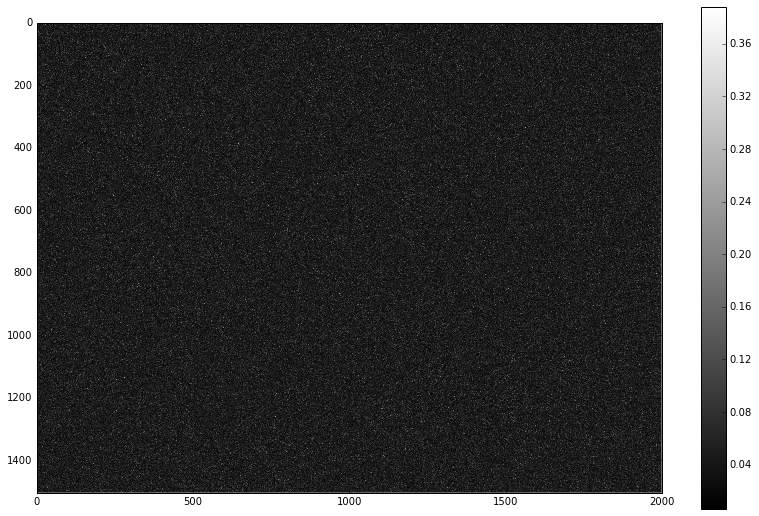

In [24]:
plt.imshow(ase.dark_frame.value, interpolation='none', aspect='equal', cmap='gray')
plt.colorbar()

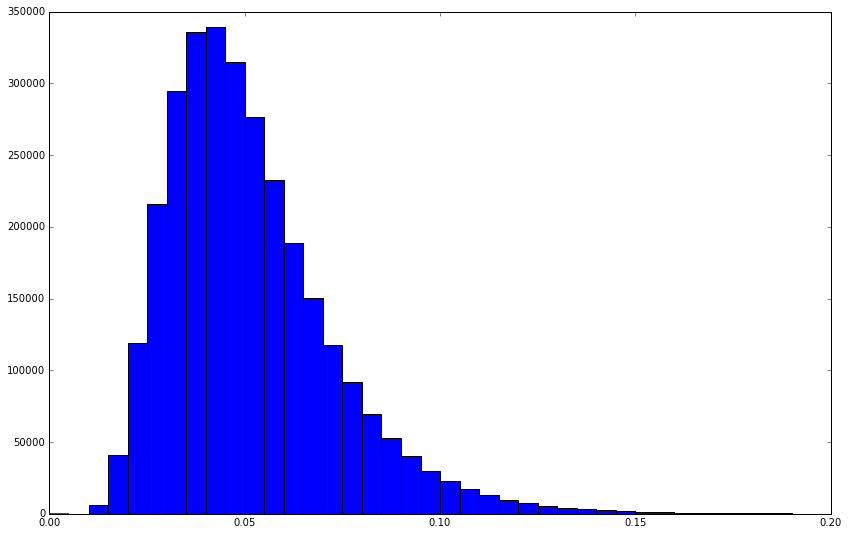

In [25]:
hist(ase.dark_frame.value.ravel(), bins=np.arange(0,0.2,0.005));

## Calculate a sky image

In [26]:
centre = '16h00m00s +57d30m00s'

In [27]:
t = Time.now()

In [28]:
noiseless_i1 = ase.make_noiseless_image(centre, t, "i1", zl=zl)
noiseless_i2 = ase.make_noiseless_image(centre, t, "i2", zl=zl)
noiseless_i3 = ase.make_noiseless_image(centre, t, "i3", zl=zl)
noiseless_z1 = ase.make_noiseless_image(centre, t, "z1", zl=zl)
noiseless_z2 = ase.make_noiseless_image(centre, t, "z2", zl=zl)
noiseless_z3 = ase.make_noiseless_image(centre, t, "z3", zl=zl)

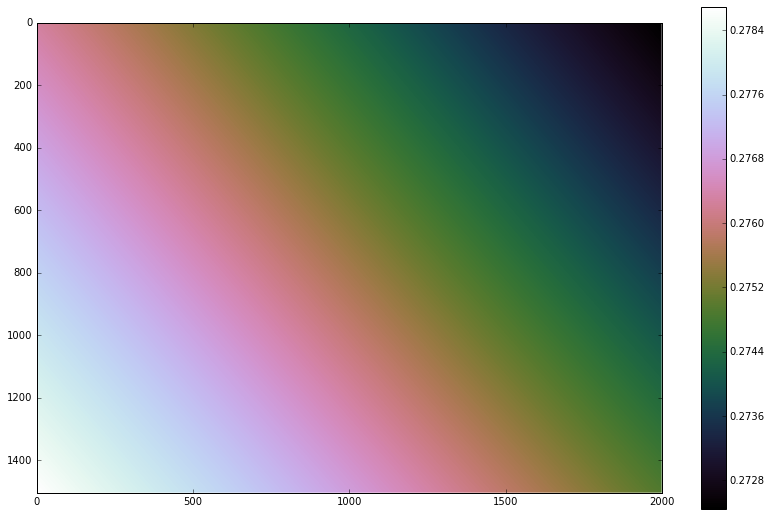

In [29]:
plt.imshow(noiseless_i2, interpolation='none', aspect='equal', cmap='cubehelix')
plt.colorbar()

### Create some 'realistic' images

In [30]:
real_i2 = ase.make_image_real(noiseless_i2, exp_time = 600 * u.second)
real_i2_sub = ase.make_image_real(noiseless_i2, exp_time = 600 * u.second, subtract_dark=True)

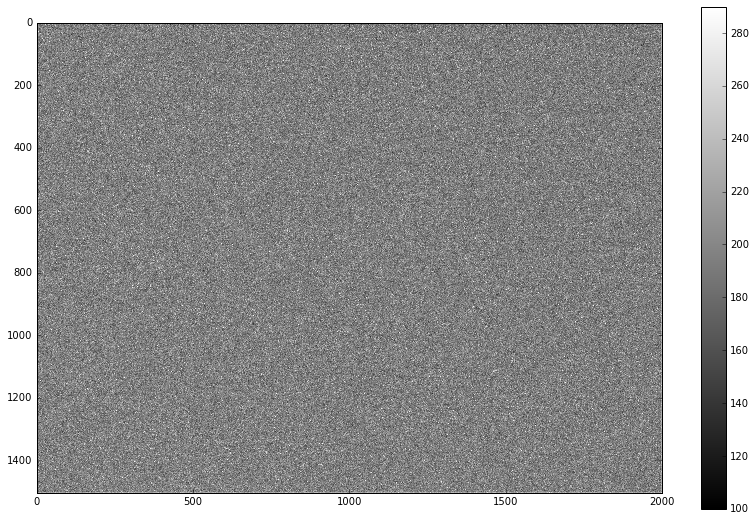

In [31]:
plt.imshow(real_i2, interpolation='none', aspect='equal', cmap='gray', vmax=290, vmin=100)
plt.colorbar()

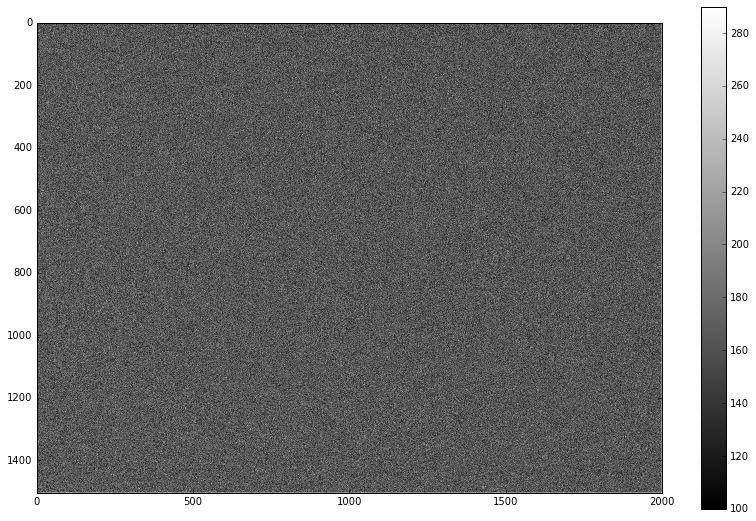

In [32]:
plt.imshow(real_i2_sub, interpolation='none', aspect='equal', cmap='gray', vmax=290, vmin=100)
plt.colorbar()

(100, 290)

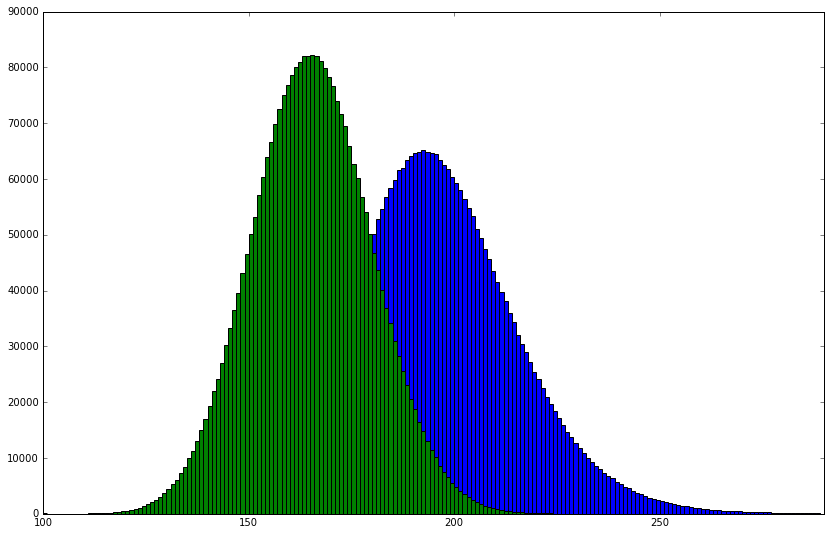

In [33]:
hist(real_i2.data.ravel(), bins=np.arange(100,290));
hist(real_i2_sub.data.ravel(), bins=np.arange(100,290));
plt.xlim(100,290)

Huh, github problems.

In [54]:
import math

In [55]:
def theta_max(F):
    return math.atan(1/(2*F))

In [56]:
def lambda_shift(theta, n_eff):
    return math.sqrt(1 - (math.sin(theta)/n_eff)**2)

In [57]:
def NB_filter(wave, wave_c, FWHM, w):
    if abs(wave - wave_c) > 0.5*(1 + w)*FWHM:
        return 0.0
    elif abs(wave - wave_c) < 0.5*(1-w)*FWHM:
        return 1.0
    else:
        return 1 - (abs(wave - wave_c) - 0.5*(1-w)*FWHM)/(w*FWHM) 

In [58]:
def fast_NB_filter(wave, wave_c, FWHM, w, F, n_eff, n_thetas):
    thetas = np.linspace(0, theta_max(F), n_thetas)
    num = math.fsum([NB_filter(wave/lambda_shift(theta, n_eff), wave_c, FWHM, w)*math.sin(theta) for theta in thetas])
    denom = math.fsum(math.sin(theta) for theta in thetas)
    return num/denom

In [59]:
481/90

5.344444444444444

In [60]:
waves = zl.waves.value
rc = (0.71 + 0.859) / 2.0
rf = 0.859 - 0.71
rw = 0.059